In [ ]:
!git clone https://github.com/andreazenotto/mesotheliomaSemiSupervisedClassification.git

In [3]:
%%capture
!apt update && apt install -y openslide-tools
!pip install openslide-python

In [ ]:
import os
from tqdm import tqdm
import sys
import shutil
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
from pathlib import Path

import openslide

sys.path.append('mesotheliomaSemiSupervisedClassification/src')

from simclr import *
from attention_mil import *
from wsi_utils import *

In [ ]:
def get_patch_coords(patch_folder):
    coords = []
    patch_files = sorted(Path(patch_folder).glob("patch_*.png"))

    pattern = re.compile(r"patch_(\d+)_(\d+)\.png")

    for patch_path in patch_files:
        match = pattern.search(patch_path.name)
        if match:
            x, y = map(int, match.groups())
            coords.append((x, y))

    return coords


def compute_attention_map(model, patch_batch):
    attn_scores = model.mha(patch_batch, patch_batch, return_attention_scores=True)[1]  # shape: (B, H, T, T)
    diag_scores = tf.reduce_mean(tf.linalg.diag_part(attn_scores), axis=1)  # shape: (T,)
    return diag_scores.numpy()[0]


def build_wsi_attention_heatmap(patch_coords, att_scores, wsi_size, patch_size=224):
    heatmap = np.full((wsi_size[1] // patch_size, wsi_size[0] // patch_size), np.nan)  # shape: H x W

    for (x, y), score in zip(patch_coords, att_scores):
        i = y // patch_size
        j = x // patch_size
        heatmap[i, j] = score
        
    return np.array(heatmap)


def overlay_heatmap_on_wsi(slide, heatmap):
    mask = np.isnan(heatmap)
    heatmap_filled = np.copy(heatmap)
    heatmap_filled[mask] = np.nanmin(heatmap)

    # # Between 0 and 255
    norm_heatmap = (heatmap_filled - np.min(heatmap_filled)) / (np.ptp(heatmap_filled) + 1e-8)
    norm_heatmap = (norm_heatmap * 255).astype(np.uint8)

    # Invert heatmap 'logic'
    norm_heatmap = 255 - norm_heatmap

    a, b, _ = np.array(slide).shape
    heatmap = cv2.resize(norm_heatmap, (b, a))
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Resize heatmap to match WSI size
    overlay = cv2.addWeighted(np.array(slide), 0.6, heatmap_color, 0.4, 0)

    return overlay


def show_maps(name, image, heatmap, output_dim = (960, 720)):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    image = cv2.resize(np.array(image), output_dim)
    # Input
    axs[0].imshow(image); axs[0].axis('off'); axs[0].set_title(f'Original ({name})', fontsize=8)
    heatmap = cv2.resize(heatmap, output_dim)
    # Overlay heatmap
    axs[1].imshow(heatmap); axs[1].axis('off'); axs[1].set_title(f'Overlay ({name})', fontsize=8)
    plt.tight_layout(); plt.show()

In [ ]:
def xget_images(directory, slide_name):
    labels = []
    all_images = []

    mapping = {
        "epithelioid": [1, 0, 0],
        "sarcomatoid": [0, 1, 0],
        "biphasic": [0, 0, 1]
    }

    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        class_name = class_dir.split('_')[1].lower()
        if os.path.isdir(class_path):
            for wsi_dir in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
                if wsi_dir == slide_name:
                    images = []
                    wsi_path = os.path.join(class_path, wsi_dir)
                    if os.path.isdir(wsi_path):
                        for img_name in os.listdir(wsi_path):
                            img_path = os.path.join(wsi_path, img_name)
                            images.append(img_path)
                    all_images.append(images)
                    labels.append(mapping[class_name])
                else:
                    continue

    return all_images, labels


def xextract_features(patches_dir, backbone_model, slide_name,  batch_size):
    all_features = []
    wsi_list, labels = xget_images(patches_dir, slide_name)
    strategy = tf.distribute.MirroredStrategy()

    with strategy.scope():
        @tf.function
        def extract_step(batch):
            features = backbone_model(batch, training=False)
            return features

        for wsi_images in tqdm(wsi_list, desc="Extracting features"):
            features_list = []
            path_ds = tf.data.Dataset.from_tensor_slices(wsi_images)
            image_ds = path_ds.map(load_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
            image_ds = image_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

            dist_ds = strategy.experimental_distribute_dataset(image_ds)

            for dist_batch in dist_ds:
                per_replica_features = strategy.run(extract_step, args=(dist_batch,))
                batch_features = tf.concat(strategy.gather(per_replica_features, axis=0), axis=0)
                features_list.extend(batch_features.numpy())

            all_features.append(np.array(features_list))

    return np.array(all_features, dtype=object), np.array(labels, dtype=np.float32)


def hashMapPred(x):
    labels = np.array(['epithelioid', 'sarcomatoid', 'biphasic'])
    return labels[x[0]][0]

## Pipeline to compute and plot Attention Map of a WSI

In [ ]:
# WSI selection
slide_name = "M-65"

# Paths
wsi_dir = f"/kaggle/input/wsi-selected/{slide_name}.ndpi"
patches_dir = "/kaggle/input/camel-dataset"
backbone_path = "/kaggle/input/camel-backbone-model/tensorflow2/default/1/best_backbone.h5"
model_path = "/kaggle/input/camel-mil-model/keras/default/1/best_mil.keras"

# Backbone
backbone = tf.keras.models.load_model(backbone_path)

# Slide and its size at the same level used on dataset sampling
slide = openslide.OpenSlide(wsi_dir)
slide_size = slide.level_dimensions[1]

# Extract features and generate the dataset
features, labels = xextract_features(patches_dir, backbone, slide_name, batch_size=256)
dataset = generate_dataset(features, labels, num_classes=3, batch_size=1)

Extracting features: 100%|██████████| 1/1 [00:17<00:00, 17.47s/it]


In [ ]:
# Inference with custom MIL
model = tf.keras.models.load_model(model_path)

for i, (x, y) in enumerate(dataset):

    attn_diag = compute_attention_map(model, x)

    # Coords extracted from file name
    label_path = f"patches_{hashMapPred(np.array(y, dtype='bool'))}"
    specific_patch_dir = os.path.join(patches_dir, label_path, slide_name)
    patch_coords = get_patch_coords(specific_patch_dir)

    # Build heatmap
    heatmap = build_wsi_attention_heatmap(patch_coords, attn_diag, slide_size)

    # Build overlay
    red_slide_size = slide.level_dimensions[3]
    thumbnail = slide.get_thumbnail(red_slide_size)
    attention_map = overlay_heatmap_on_wsi(thumbnail, heatmap=heatmap)

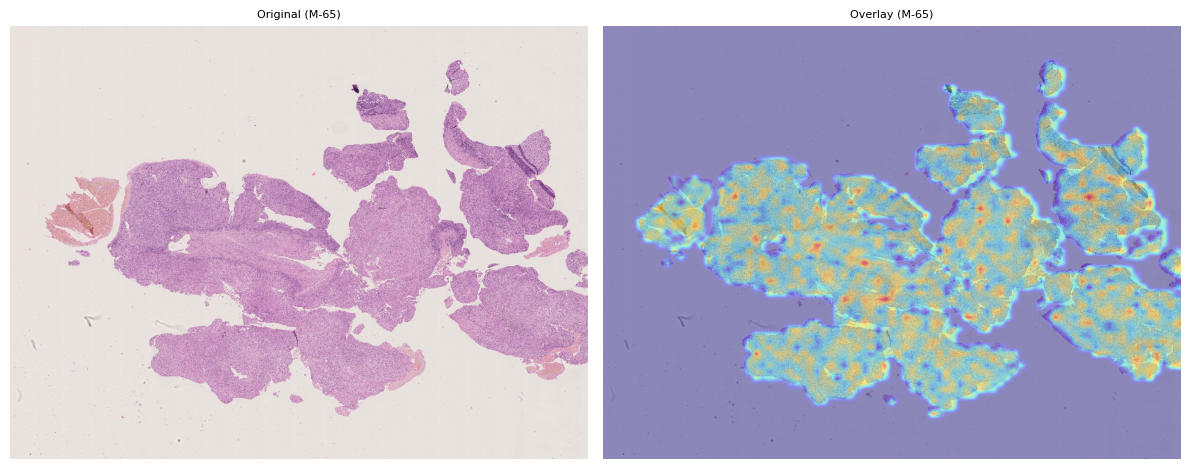

In [ ]:
show_maps(slide_name, thumbnail, attention_map)